# Cheatsheet for common operations<a id="top"></a>

_Developed by Davíd Brakenhoff (Artesia) on July 19, 2019_
<hr>

This notebook contains code snippets for performing common operations on water balances.

## Contents

- [Simplest way to simulate a waterbalance](#1)
- [Simplest way to simulate water quality](#1.1)
- [Comparing Python waterbalance to Excel waterbalance](#2)
- [Export simulation results to csv](#3)
- [Extend simulation period of existing waterbalance](#4)
- [Change an input parameter value after first simulation](#5)
- [Add a bucket to an existing EAG](#6)

Import relevant modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import waterbalans as wb

## [Simplest way to run a waterbalance](#top)<a id="1"></a>

The simplest way to run a waterbalance is to use the `wb.run_eag_by_name()` function. This function picks up all the relevant CSVs from the provided `csvdir` and does all the work for you.

In [2]:
e = wb.run_eag_by_name("2250-EAG-2", csvdir="../../data/input_csv")

2021-07-08 18:13:29,094 | create_eag - INFO : Creating EAG object for '2250-EAG-2'
2021-07-08 18:13:29,111 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2021-07-08 18:13:29,119 | get_series - INFO : Adding Local timeseries 'Neerslag' for Bucket '-9999'.
2021-07-08 18:13:29,120 | get_series - INFO : Adding Local timeseries 'Uitlaat4' for Bucket '-9999'.
2021-07-08 18:13:29,122 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 1' for Bucket '-9999'.
2021-07-08 18:13:29,124 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:13:29,127 | get_series - INFO : Adding Local timeseries 'Peil' for Bucket '-9999'.
2021-07-08 18:13:29,129 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:13:29,131 | get_series - INFO : Adding Local timeseries 'Gemaal3Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:13:29,133 | get_series - INFO : A

## [Simplest way to simulate water quality](#top)<a id="1.1"></a>

Simulating water quality requires a bit more work, the file containing the water quality parameters has to be loaded and edited somewhat to work nice with the Python module.

In [5]:
# bestand met concentraties van stof per flux
fosfor = pd.read_csv(r"../../data/input_csv/stoffen_fosfor_85_2250-EAG-2.csv", delimiter=";", decimal=",")
fosfor.columns = [icol.capitalize() for icol in fosfor.columns]
fosfor.replace("Riolering", "q_cso", inplace=True)
fosfor["Waarde"] = pd.to_numeric(fosfor["Waarde"])
fosfor["StofIncrement"] = pd.to_numeric(fosfor["Stofincrement"])
fosfor.rename(columns={"Inlaattype": "InlaatType",
                       "Reekstype": "ReeksType"}, inplace=True)
# fosfor

Simulate the water quality twice (once for the lower limit, and once for the upper limit).

In [6]:
# Simuleer de waterkwaliteit (ondergrens en bovengrens)
mass_in, mass_out, mass_fosfor = e.simulate_wq(fosfor)
mass_in_max, mass_out_max, mass_fosfor_max = e.simulate_wq(
    fosfor, increment=True)

# Bereken de concentratie
C_fosfor = mass_fosfor / e.water.storage["storage"]
C_fosfor_max = mass_fosfor_max / e.water.storage["storage"]

2021-07-08 18:14:12,477 | simulate_wq - INFO : Simulating water quality: 2250-EAG-2...
2021-07-08 18:14:12,506 | simulate_wq - WARNING : Provided concentrations not used, no fluxes for: {'inlaat1', 'inlaat3', 'inlaat4', 'inlaat2'}
2021-07-08 18:14:12,509 | get_series - INFO : Get Constant timeseries 'afstroming'.
2021-07-08 18:14:12,511 | get_series - INFO : Get Constant timeseries 'berekende inlaat'.
2021-07-08 18:14:12,513 | get_series - INFO : Get Constant timeseries 'drain'.
2021-07-08 18:14:12,516 | get_series - INFO : Get Constant timeseries 'kwel'.
2021-07-08 18:14:12,518 | get_series - INFO : Get Constant timeseries 'neerslag'.
2021-07-08 18:14:12,520 | get_series - INFO : Get Constant timeseries 'uitspoeling'.
2021-07-08 18:14:12,522 | get_series - INFO : Get Constant timeseries 'verhard'.
2021-07-08 18:14:12,527 | get_series - INFO : Get Constant timeseries 'q_cso'.
2021-07-08 18:14:13,504 | simulate_wq - INFO : Simulation water quality succesfully completed in 1.0s.
2021-07-

Visualization of the results:

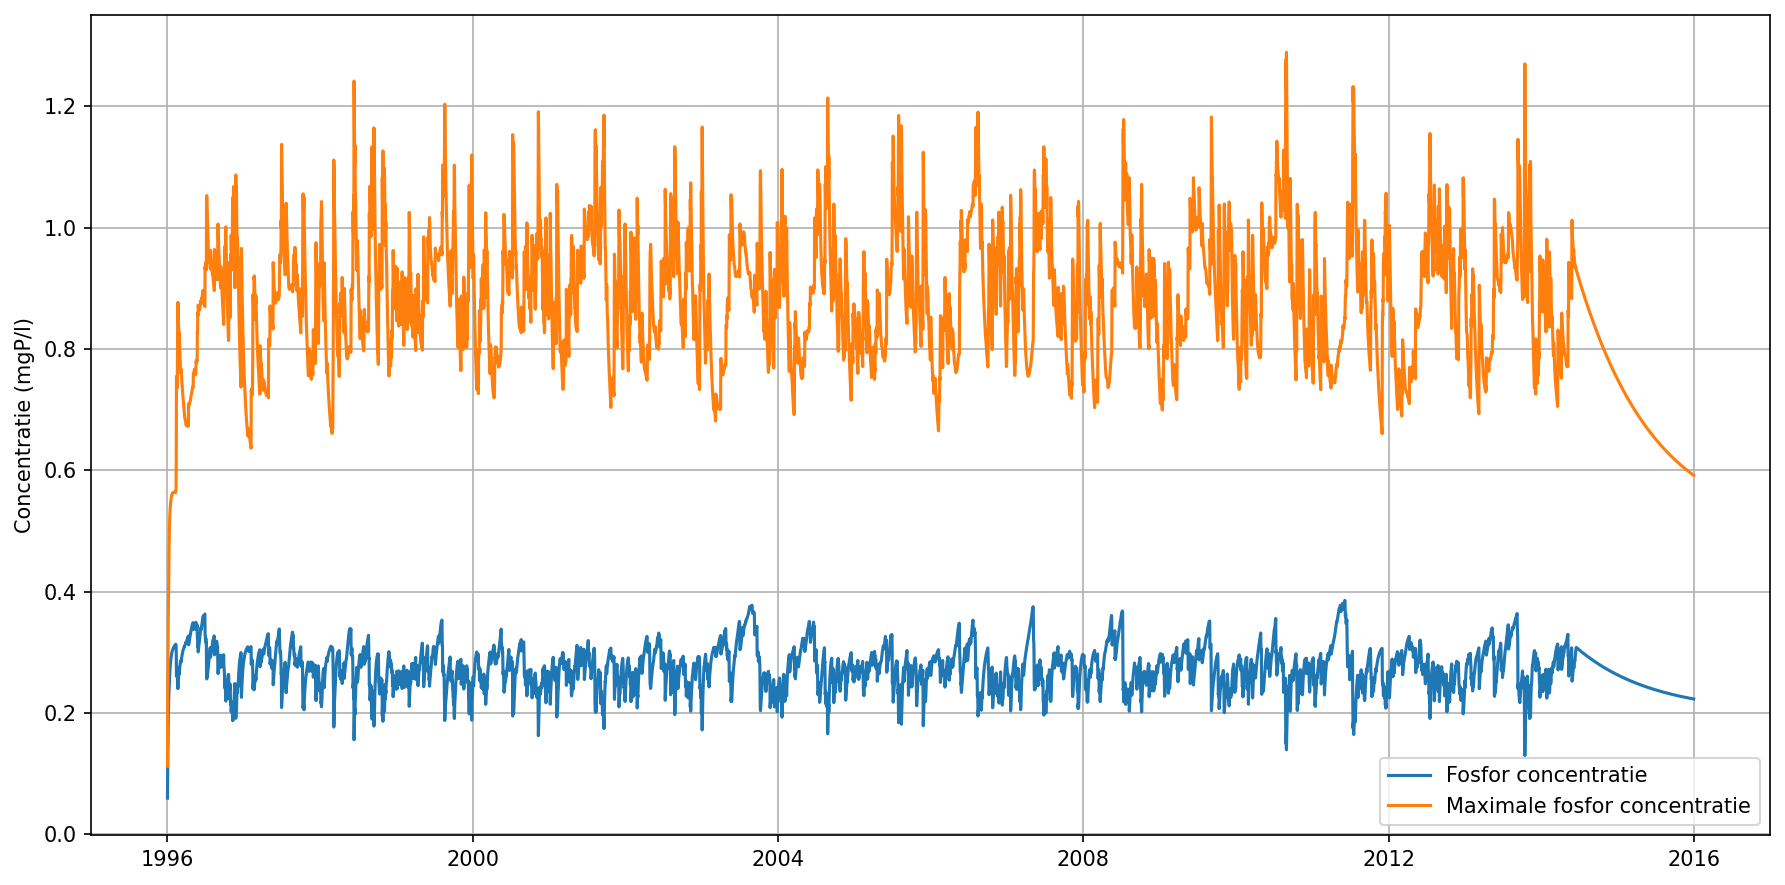

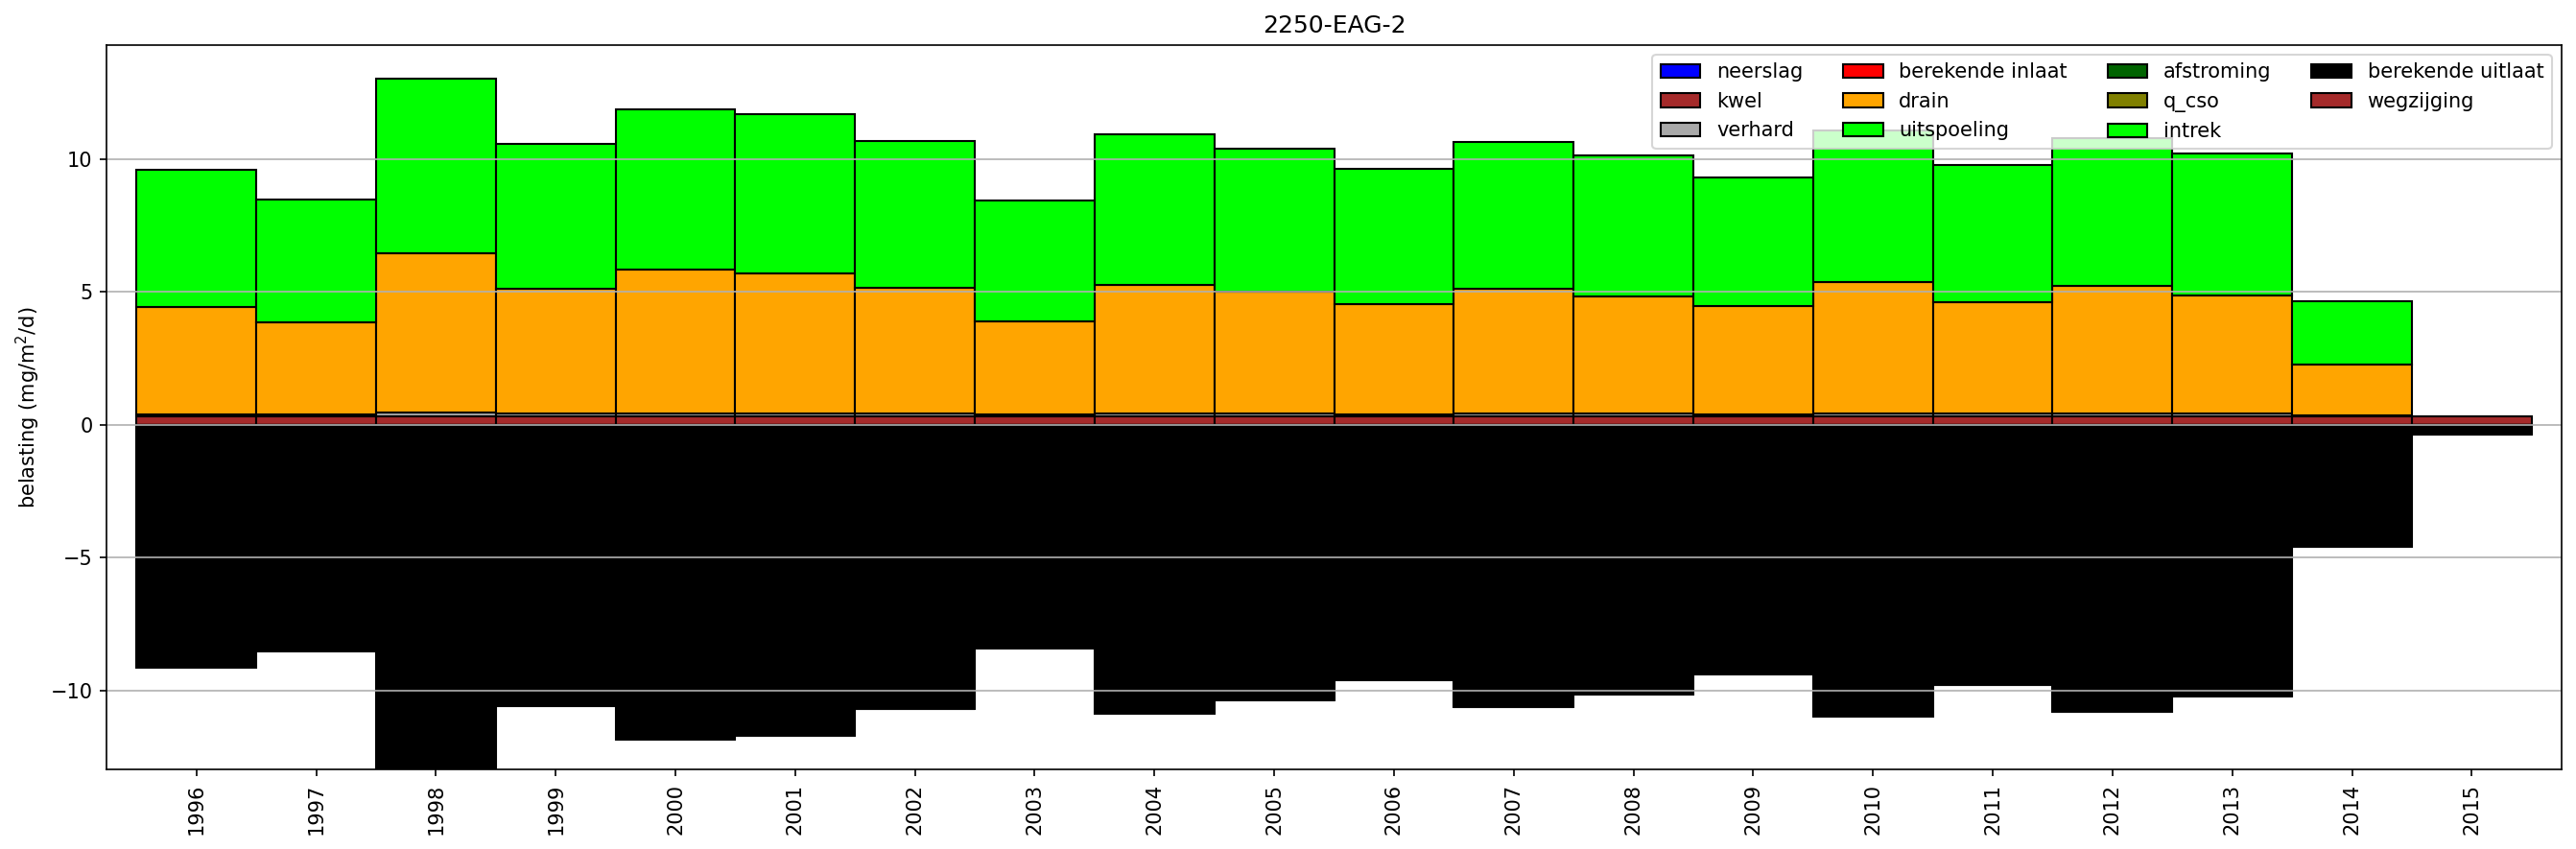

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
ax.plot(C_fosfor.loc[:"2015"].index, C_fosfor.loc[:"2015"], label="Fosfor concentratie")
ax.plot(C_fosfor_max.loc[:"2015"].index, C_fosfor_max.loc[:"2015"], label="Maximale fosfor concentratie")
ax.legend(loc="best")
ax.set_ylabel("Concentratie (mgP/l)")
ax.grid(b=True)
fig.tight_layout()

ax = e.plot.wq_loading(mass_in, mass_out, tmax="2015")

## [Comparing Python waterbalance to Excel waterbalance](#top)<a id="2"></a>

Comparing to an existing Excel waterbalance requires the data from this Excel balance to be stored somewhere. If this data is available as a pickled DataFrame (as it is in the repository), you can use the function `wb.utils.comare_to_excel_balance()`

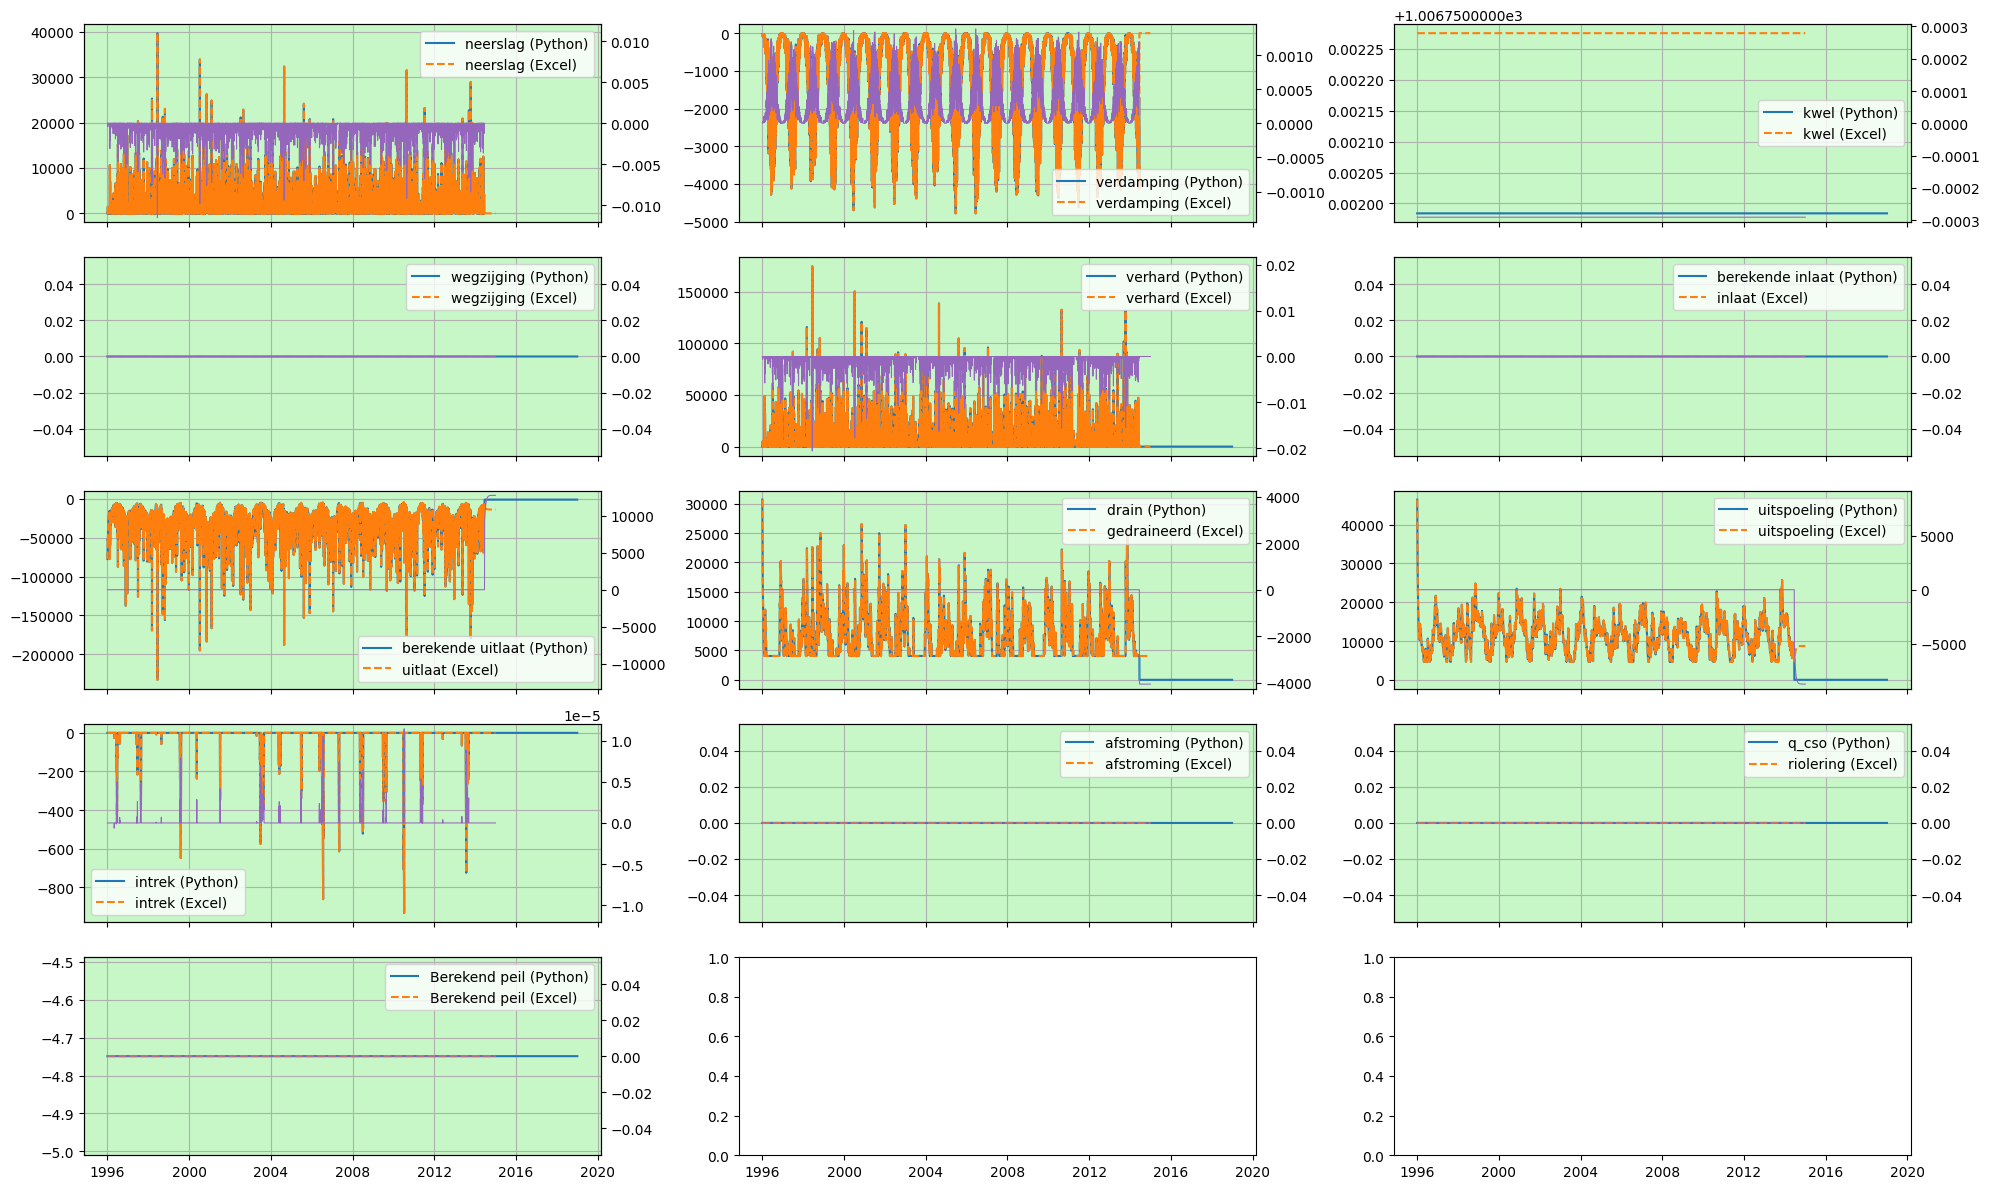

In [8]:
f = wb.utils.compare_to_excel_balance(e, pickle_dir="../../data/excel_pklz")

## [Export simulation results to csv](#top)<a id="3"></a>

The desired output is generally the fluxes or the water quality of the surface water bucket. Each of these parameters is easily obtained as a DataFrame. Exporting to a CSV file is as easy as calling `df.to_csv('<csv_name>.csv')`.

In [9]:
fluxes = e.aggregate_fluxes()

In [10]:
old_water_level = e.water.level.copy()

In [11]:
# fluxes.to_csv("test.csv")

## [Extend simulation period of existing waterbalance](#top)<a id="4"></a>

Extending the simulation period of an existing water balance requires updating the timeseries by adding them again, and then re-running the simulation.

If there are timeseries that are not available in FEWS or KNMI, the timeseries for the new period must be added manually.

In [12]:
df = pd.read_csv("../../data/input_csv/reeks_85_2250-EAG-2.csv", sep=";")
e.add_series_from_database(df, tmin="1995-12-31", tmax="2019")

2021-07-08 18:14:32,219 | add_series_from_database - INFO : Parsing timeseries from database export and adding to EAG.
2021-07-08 18:14:32,226 | get_series - INFO : Adding Local timeseries 'Neerslag' for Bucket '-9999'.
2021-07-08 18:14:32,227 | get_series - INFO : Adding Local timeseries 'Uitlaat4' for Bucket '-9999'.
2021-07-08 18:14:32,228 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 1' for Bucket '-9999'.
2021-07-08 18:14:32,231 | get_series - INFO : Adding Local timeseries 'Gemaal1Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:14:32,232 | get_series - INFO : Adding Local timeseries 'Peil' for Bucket '-9999'.
2021-07-08 18:14:32,233 | get_series - INFO : Adding Local timeseries 'Gemaal2Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:14:32,234 | get_series - INFO : Adding Local timeseries 'Gemaal3Debiet Pomp 2' for Bucket '-9999'.
2021-07-08 18:14:32,235 | get_series - INFO : Adding Local timeseries 'Gemaal3Debiet Pomp 1' for Bucket '-9999'.
2021-07-08 18:14:

In [13]:
e.simulate(e.get_parameter_df(), tmin="1996", tmax="2019")

2021-07-08 18:14:34,092 | simulate - INFO : Simulating: 2250-EAG-2...
2021-07-08 18:14:34,095 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2021-07-08 18:14:34,118 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2021-07-08 18:14:34,129 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2021-07-08 18:14:34,149 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2021-07-08 18:14:34,159 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2021-07-08 18:14:34,180 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2021-07-08 18:14:34,190 | simulate - INFO : Using observed waterlevels in simulation!
2021-07-08 18:14:34,191 | simulate - WARNING : 'QInMax_1' is equal to 0. Assuming this means there is no limit to inflow.
2021-07-08 18:14:34,193 | simulate - WARNING : 'QOutMax_1' is equal to 0. Assuming this means there is no limit to out

There is no evaporation data for the later period, hence the change in the behavior of the water balance after 2015.

<AxesSubplot:title={'center':'2250-EAG-2'}, ylabel='<- uitstroming | instroming ->'>

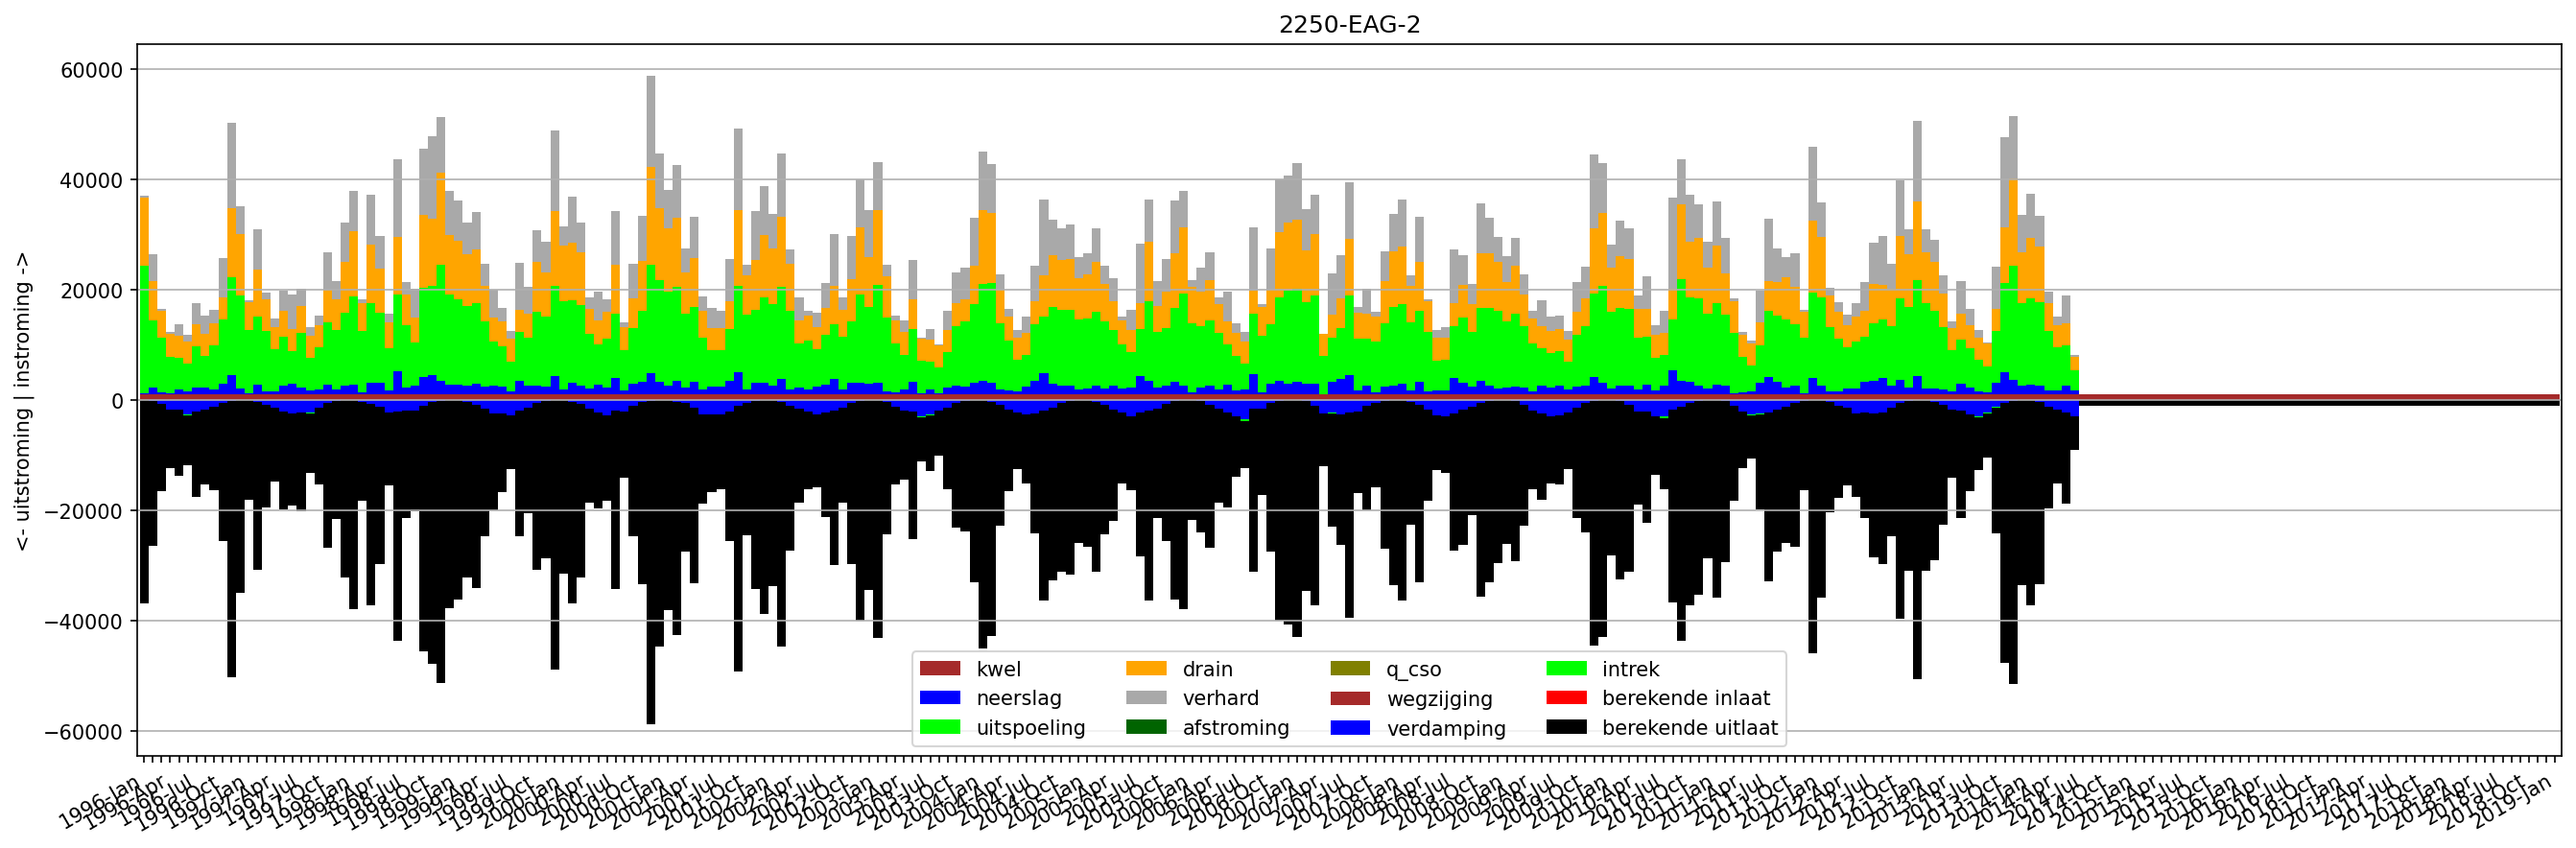

In [14]:
e.plot.aggregated();

## [Change an input parameter value after first simulation](#top)<a id="5"></a>

To modify the parameters of an EAG after it has been simulated:
1. Get the parameters used in the previous simulation
2. Modify the parameters you wish to change
3. Pass the new parameters to a new call to `e.simulate()`

Get the parameters:


In [15]:
new_params = e.get_parameter_df()
new_params.tail()

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
47,Water,85000000,hTargetMin,1,0.2
48,Water,85000000,hTargetMax,1,0.001
49,Water,85000000,hBottom,1,-5.33
50,Water,85000000,QInMax,1,0
51,Water,85000000,QOutMax,1,0


In [16]:
# edit hTargetMax
new_params.loc[48, "Waarde"] = 0.1
new_params.tail()

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
47,Water,85000000,hTargetMin,1,0.2
48,Water,85000000,hTargetMax,1,0.1
49,Water,85000000,hBottom,1,-5.33
50,Water,85000000,QInMax,1,0
51,Water,85000000,QOutMax,1,0


Simulate the Eag again:

In [17]:
e.simulate(new_params, tmin="1996", tmax="2019")

2021-07-08 18:14:46,306 | simulate - INFO : Simulating: 2250-EAG-2...
2021-07-08 18:14:46,315 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2021-07-08 18:14:46,331 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2021-07-08 18:14:46,348 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2021-07-08 18:14:46,359 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2021-07-08 18:14:46,375 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2021-07-08 18:14:46,403 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2021-07-08 18:14:46,410 | simulate - INFO : Using observed waterlevels in simulation!
2021-07-08 18:14:46,412 | simulate - WARNING : 'QInMax_1' is equal to 0. Assuming this means there is no limit to inflow.
2021-07-08 18:14:46,413 | simulate - WARNING : 'QOutMax_1' is equal to 0. Assuming this means there is no limit to out

Plot the results

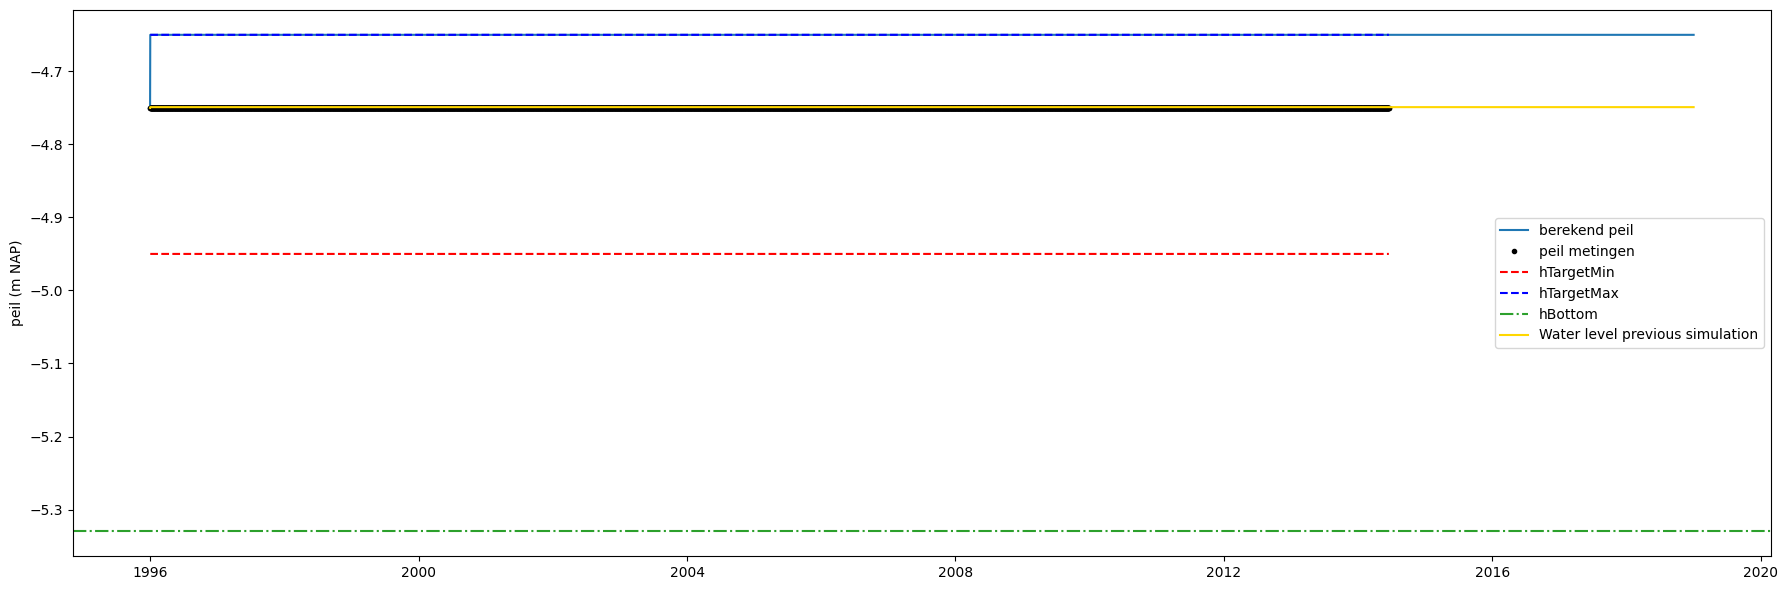

In [18]:
ax = e.plot.water_level()
ax.plot(old_water_level.index, old_water_level, color="gold", label="Water level previous simulation")
ax.legend(loc="best");

## [Add a bucket to an existing EAG](#top)<a id="6"></a>

Create a new Bucket.

In [19]:
new_bucket = wb.Verhard(10, e, None, area=10000.)

It is automatically added to the EAG:

In [20]:
e.get_modelstructure()

,Name,Area,BucketObj
ID,,,
85000282,Verhard,2915860.0,<85000282: Verhard bucket with area 2915860.0>
85000283,Onverhard,1964984.0,<85000283: Onverhard bucket with area 1964984.0>
85000284,Drain,1964984.0,<85000284: Drain bucket with area 1964984.0>
85000288,Onverhard,570826.0,<85000288: Onverhard bucket with area 570826.0>
85000289,Drain,570826.0,<85000289: Drain bucket with area 570826.0>
10,Verhard,10000.0,<10: Verhard bucket with area 10000.0>
85000000,Water,629220.0,<85000000: Water bucket with area 629220.0>


Get the parameters including the default values for the new bucket.

In [21]:
params_with_new_bucket = e.get_parameter_df()

View the parameters of the new bucket (adjust if you want):

In [22]:
params_with_new_bucket.loc[params_with_new_bucket.BakjeID == 10]

,Bakje,BakjeID,ParamCode,Laagvolgorde,Waarde
46,Verhard,10,hMax,1,0.002
47,Verhard,10,hMax,2,1
48,Verhard,10,hInit,2,0.5
49,Verhard,10,EFacMin,1,1
50,Verhard,10,EFacMax,1,1
51,Verhard,10,RFacIn,2,0.1
52,Verhard,10,RFacOut,2,0.1
53,Verhard,10,por,2,0.2


Note the presence of the new bucket in the simulation log:

In [23]:
e.simulate(params_with_new_bucket, tmin="1996", tmax="2019")

2021-07-08 18:15:14,036 | simulate - INFO : Simulating: 2250-EAG-2...
2021-07-08 18:15:14,040 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 85000282
2021-07-08 18:15:14,050 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000283
2021-07-08 18:15:14,068 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000284
2021-07-08 18:15:14,083 | simulate - INFO : Simulating the waterbalance for bucket: Onverhard 85000288
2021-07-08 18:15:14,101 | simulate - INFO : Simulating the waterbalance for bucket: Drain 85000289
2021-07-08 18:15:14,122 | simulate - INFO : Simulating the waterbalance for bucket: Verhard 10
2021-07-08 18:15:14,152 | simulate - WARNING : Warning: {'Qkwel'} not in series. Assumed equal to 0!
2021-07-08 18:15:14,167 | simulate - INFO : Simulating the waterbalance for bucket: Water 85000000
2021-07-08 18:15:14,177 | simulate - INFO : Using observed waterlevels in simulation!
2021-07-08 18:15:14,178 | simulate - WARNING